In [1]:
#Importing Packages
import numpy as np
import xarray as xr
from tinygp import kernels, GaussianProcess
import jax
import jax.numpy as jnp
from jax import random
import matplotlib.pyplot as plt
import arviz as az
from src.model_fitting_functions import run_inference
from src.examples_functions import create_levels,tinygp_2process_model,truth_posterior_predictive,bias_posterior_predictive,posterior_predictive_realisations
import geopandas as gpd
import cartopy.crs as ccrs

plt.rcParams['lines.markersize'] = 3
plt.rcParams['lines.linewidth'] = 0.4

rng_key = random.PRNGKey(3)
rng_key, rng_key_ = random.split(rng_key)
jax.config.update("jax_enable_x64", True)

In [2]:
#Saving residual data
base_path = '/home/jez/Bias_Correction/'
nst_climate_residual_path = f'{base_path}data/ProcessedData/MetUM_Reformatted_Residual.nc'
obs_residual_path = f'{base_path}data/ProcessedData/NST_Observations_Reformatted_Residual.nc'

ds_obs_stacked = xr.open_dataset(obs_residual_path)
ds_climate = xr.open_dataset(nst_climate_residual_path)
ds_climate_stacked = ds_climate.stack(X=(('grid_longitude','grid_latitude'))).dropna('X','all')
ds_climate_stacked = ds_climate_stacked.where(ds_climate_stacked.lsm,drop=True)

In [3]:
rotated_coord_system = ccrs.RotatedGeodetic(
    13.079999923706055,
    0.5199999809265137,
    central_rotated_longitude=180.0,
    globe=None,
)
antarctica_shapefile_path = f'{base_path}data/Antarctica_Shapefile/antarctica_shapefile.shp'
antarctica_gdf = gpd.read_file(antarctica_shapefile_path)
antarctica_gdf = antarctica_gdf.to_crs(rotated_coord_system)

ERROR:fiona._env:PROJ: proj_identify: /home/jez/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.


In [4]:
ox = np.vstack(
    [
        ds_obs_stacked.glon.data,
        ds_obs_stacked.glat.data,
    ]
).T  # shape = [sites,2]
odata = jnp.array(ds_obs_stacked['Temperature Residual'].data).T
# omask = jnp.logical_not(jnp.isnan(odata)) 

cx = np.vstack(
    [
        ds_climate_stacked.glon.data,
        ds_climate_stacked.glat.data,
    ]
).T  # shape = [sites,2]
cdata = ds_climate_stacked['Mean Jan Temperature Residual'].data

In [5]:
onoise = 1
cnoise = 1e-4
jitter = 1e-5

mcmc_2process = run_inference(
    tinygp_2process_model, rng_key_, 1000, 2000,
    cx[::10],ox=ox,cdata=cdata[::10],odata=odata,onoise=onoise,cnoise=cnoise)

idata_2process = az.from_numpyro(mcmc_2process)

sample: 100%|██████████| 3000/3000 [15:09<00:00,  3.30it/s, 3 steps of size 4.24e-01. acc. prob=0.91]   



                    mean       std    median      5.0%     95.0%     n_eff     r_hat
     bkern_var      1.99      0.66      1.88      1.00      2.93   1132.09      1.00
  blengthscale      4.26      0.43      4.24      3.56      4.95    995.75      1.00
         bmean     -0.88      0.39     -0.88     -1.46     -0.19   1542.90      1.00
      kern_var      0.57      0.07      0.56      0.44      0.68   1119.64      1.00
   lengthscale      0.75      0.03      0.76      0.70      0.80   1099.52      1.00
          mean      0.79      0.13      0.79      0.58      1.01   1902.95      1.00

Number of divergences: 0
Time Taken: 914.1621632799506


In [6]:
#Saving Output from MCMC
outfile_dir = '/home/jez/Bias_Correction/data/Residual_Model/'
idata_2process.to_netcdf(f'{outfile_dir}idata_residual.nc')
#Loading Output from MCMC
outfile_dir = '/home/jez/Bias_Correction/data/Residual_Model/'
idata_2process = az.from_netcdf(f'{outfile_dir}idata_residual.nc')

In [7]:
#Realisations
ds_predictions = ds_climate.isel(grid_latitude=slice(None,None,5),grid_longitude=slice(None,None,5))
ds_predictions_stacked = ds_predictions.stack(X=('grid_longitude', 'grid_latitude'))
nx = np.vstack(
    [
        ds_predictions_stacked.glon.data,
        ds_predictions_stacked.glat.data,
    ]
).T 
onoise = 1
cnoise = 1e-4
jitter = 1e-5

npr = 20 # num_parameter_realisations
nppr = 20 # num_posterior_pred_realisations

truth_realisations = posterior_predictive_realisations(
    truth_posterior_predictive,
    nx,ox,cx,odata,cdata,idata_2process,onoise,cnoise,jitter,
    npr,nppr)

bias_realisations = posterior_predictive_realisations(
    bias_posterior_predictive,
    nx,ox,cx,odata,cdata,idata_2process,onoise,cnoise,jitter,
    npr,nppr)

ds_predictions_stacked["mean_truth"]=(['X'],  truth_realisations.mean(axis=(0,1)))
ds_predictions_stacked["std_truth"]=(['X'],  truth_realisations.std(axis=(0,1)))
ds_predictions_stacked["mean_bias"]=(['X'],  bias_realisations.mean(axis=(0,1)))
ds_predictions_stacked["std_bias"]=(['X'],  bias_realisations.std(axis=(0,1)))
ds_predictions_stacked["mean_climate"]=(['X'],  (truth_realisations+bias_realisations).mean(axis=(0,1)))
ds_predictions_stacked["std_climate"]=(['X'],  (truth_realisations+bias_realisations).std(axis=(0,1)))

ds_predictions = ds_predictions_stacked.unstack()

100%|██████████| 20/20 [02:47<00:00,  8.38s/it]


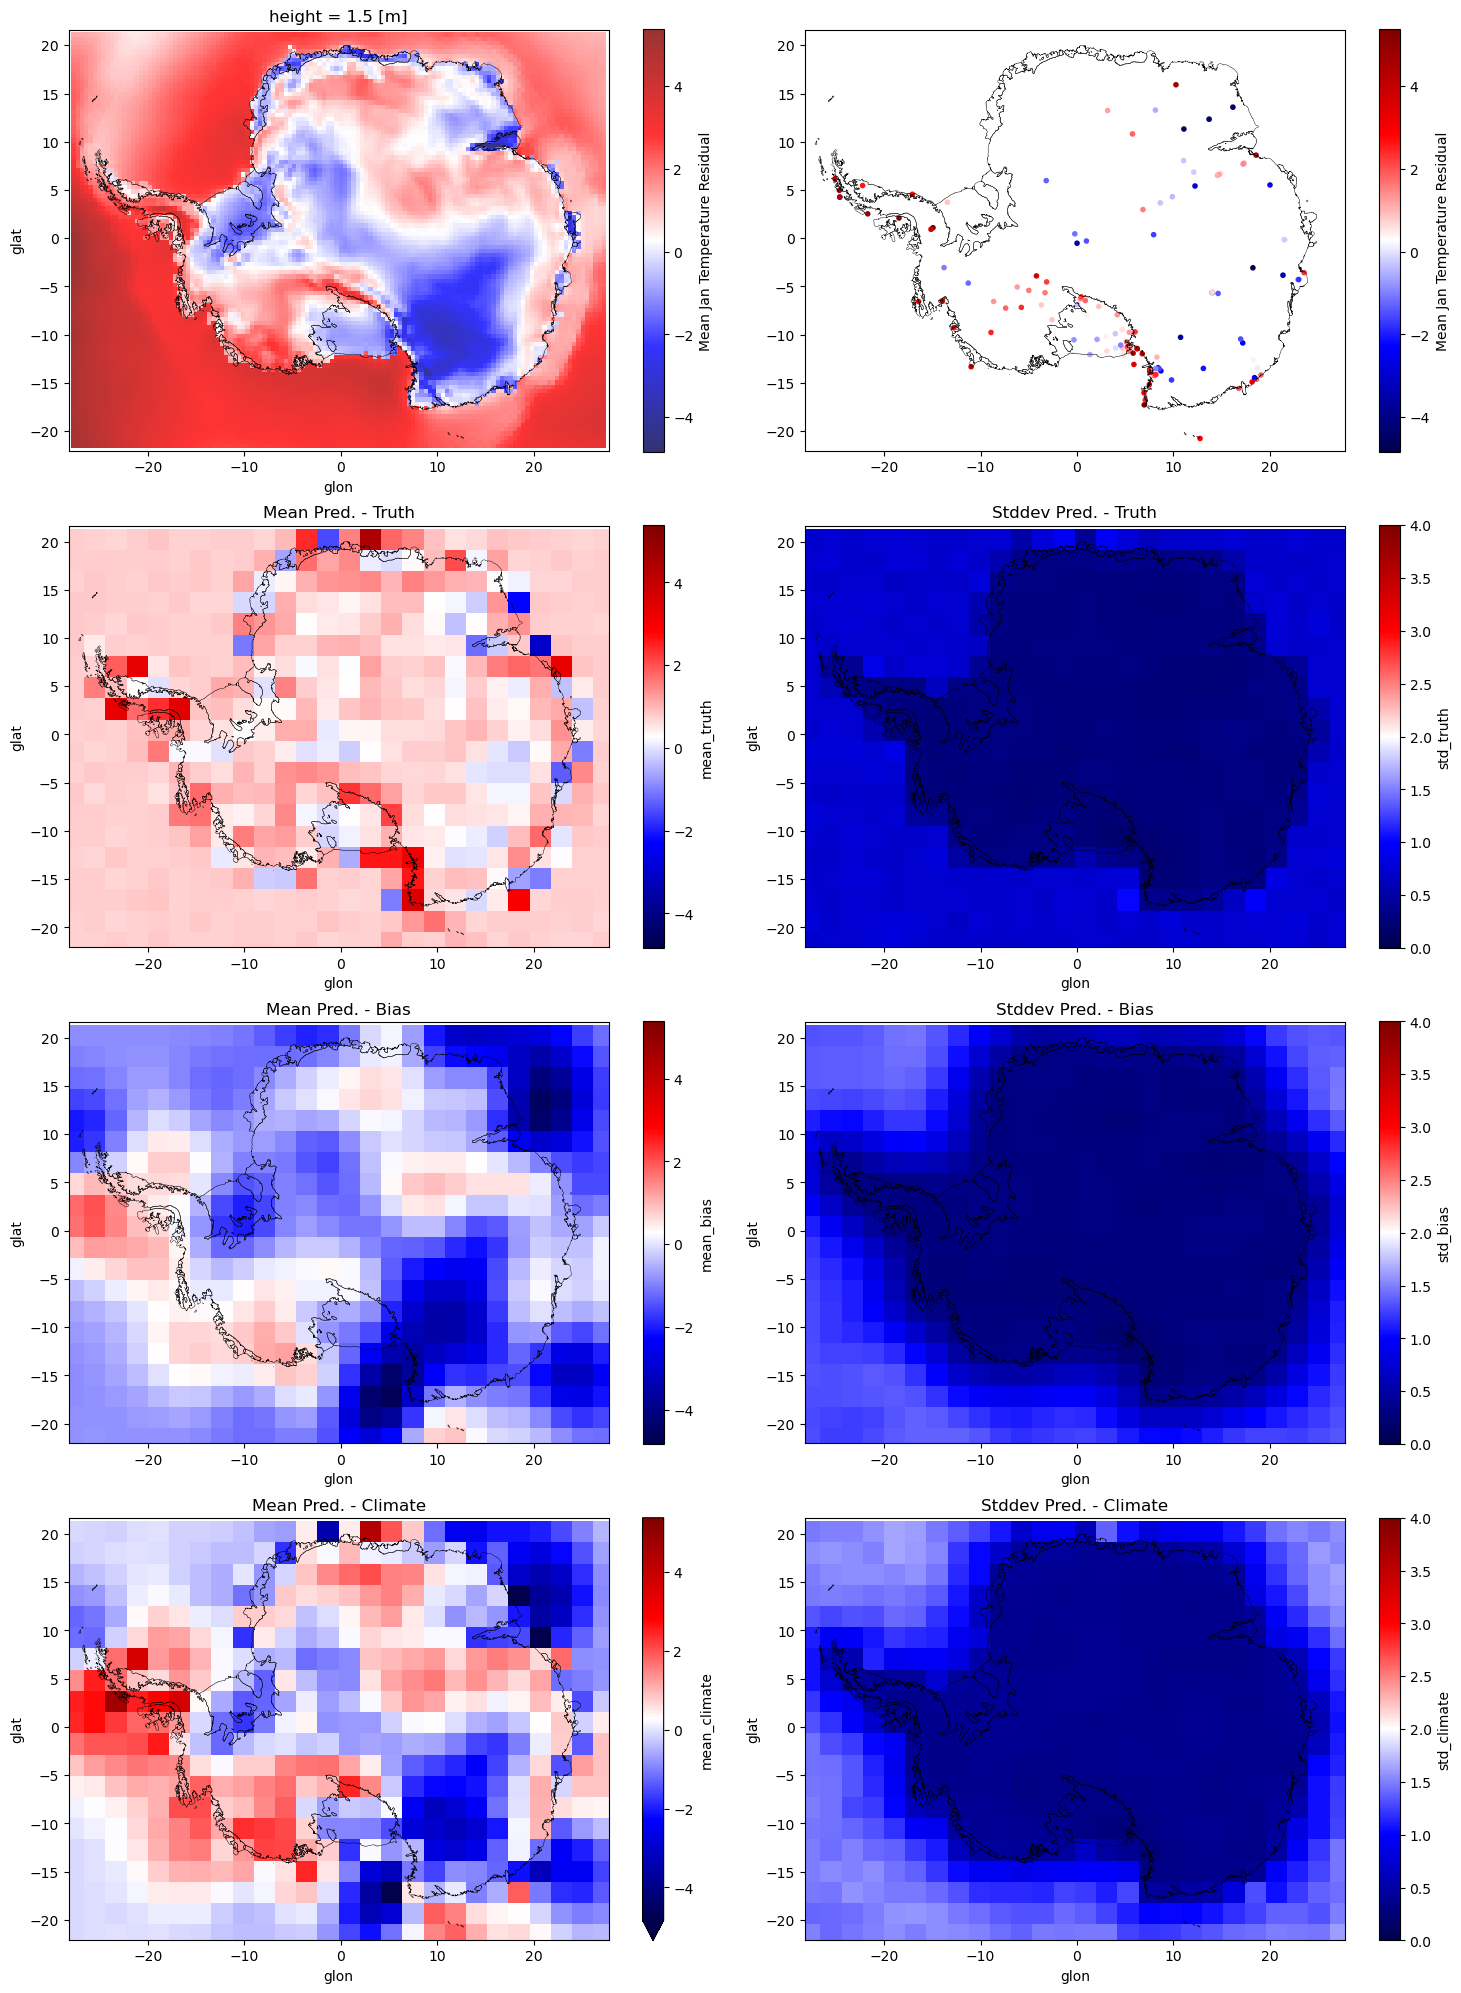

In [9]:
fig, axs = plt.subplots(4, 2, figsize=(15, 20))
da = ds_climate['Mean Jan Temperature Residual']
cmap = 'seismic'
plots=[]
variables = ['mean_truth','std_truth']
titles = ['Mean Pred. - Truth','Stddev Pred. - Truth']

vmin_mean = da.min()
vmax_mean = da.max()

da.plot.pcolormesh(x='glon',y='glat',ax=axs.ravel()[0],alpha=0.8,vmin=vmin_mean,vmax=vmax_mean,cmap=cmap)
plots.append(
    axs.ravel()[1].scatter(
    x=ox[:,0],y=ox[:,1],c=odata,vmin=vmin_mean,vmax=vmax_mean,cmap=cmap)
)

variables = ['mean_truth','std_truth',
             'mean_bias','std_bias',
             'mean_climate','std_climate']
titles = ['Mean Pred. - Truth','Stddev Pred. - Truth',
          'Mean Pred. - Bias','Stddev Pred. - Bias',
          'Mean Pred. - Climate','Stddev Pred. - Climate']
for i,var,title in zip([3,4,5,6,7,8], variables, titles):
    plt.subplot(4, 2, i)
    if var in ['mean_truth','mean_bias','mean_climate']:
        vmin,vmax = vmin_mean,vmax_mean
    else:
        vmin,vmax = 0,4
    ds_predictions[var].plot.pcolormesh(x='glon',y='glat',vmin=vmin,vmax=vmax,cmap=cmap)
    plt.title(title)

min_glon, max_glon = da.glon.min()-0.5,da.glon.max()+0.5
min_glat, max_glat = da.glat.min()-0.5,da.glat.max()+0.5
for ax in axs.ravel():
    ax.set_xlim([min_glon, max_glon])
    ax.set_ylim([min_glat, max_glat])
    antarctica_gdf.boundary.plot(ax=ax, color="k", linewidth=0.3)

for plot in plots:
    cbar = plt.colorbar(plot)
    cbar.set_label('Mean Jan Temperature Residual', rotation=90)

plt.tight_layout()